<h1><center>Implementing a Regression Tree from Scratch</center></h1>
<center><a style='font-size:16px' href=https://towardsdatascience.com/regression-trees-from-scratch-in-30-lines-of-python-8196e0ab29b2?source=friends_link&sk=890559ccf33ad9b133044398fd10233f>You can read my blog-post first to familarize with regression trees</a></center>

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Dataset 

In [2]:
data = pd.read_csv("Real-estate.csv",index_col=0)
data.columns = ['X1','X2','X3','X4','X5','X6','Y']

In [30]:
X = data.drop(data.columns[6],axis=1)
y = data.iloc[:,6]
X_train, X_test, y_train, y_test = train_test_split(X,y)

SyntaxError: invalid syntax (<ipython-input-30-98179eab0365>, line 2)

In [59]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std_data = std.fit_transform(data)

y = std_data[:,6]
X = np.delete(std_data,6,axis=1)

y = pd.DataFrame(y, columns = ['Y'])
X = pd.DataFrame(X, columns = ['X1','X2','X3','X4','X5','X6'])

y.reset_index(drop=True, inplace=True)
X.reset_index(drop=True, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X,y)


Let us visualize the correlations between features and the house prices with a simple heatmap. We use `numpy` to compute the correlations and `seaborn` for visualizations. We use a cyclic colormap to display both negative and positive correlations.

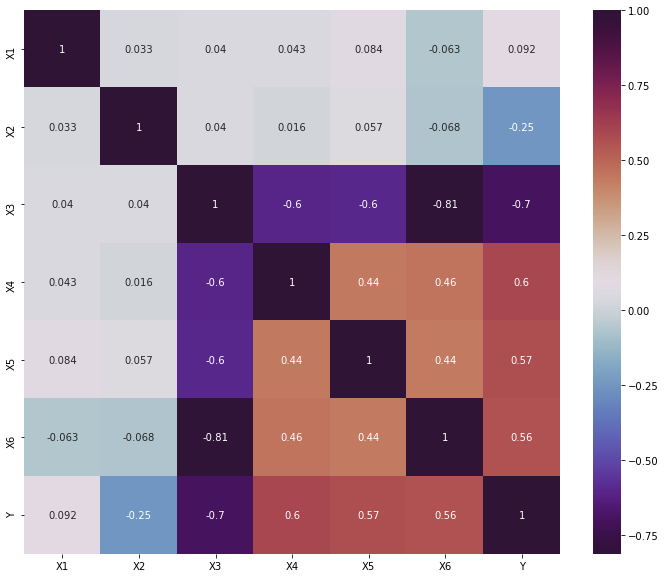

In [5]:
correlations = pd.concat([X_train, pd.Series(y_train)], axis=1).corr()
    
plt.figure(figsize=(12,10))
sns.heatmap(correlations, annot=True, cmap='twilight_shifted')
plt.show()

## Regression Tree

### Splitting Criteria: RSS

Let us now build the regression tree. We start by implementing the splitting criteria which is used to decide the most discriminative features at each step. We use $RSS$ which is computed as follows:

$$RSS =\sum_{\text {left }}\left(y_{i}-\hat{y_{L}}\right)^{2}+\sum_{\text {right }}\left(y_{i}-\hat{y_{R}}\right)^{2}$$

where $\hat{y_L} and \hat{y_r}$ are mean y-value of left and right nodes.

In [60]:
def rss(y_left, y_right):
    def squared_residual_sum(y):
        return np.sum((y - np.mean(y)) ** 2)
    
    return squared_residual_sum(y_left) + squared_residual_sum(y_right) 

def mse(ytrue, yhat) -> float:
        """
        Method to calculate the mean squared error 
        """
        # Getting the total number of samples
        n = len(ytrue)

        # Getting the residuals 
        r = ytrue - yhat 

        # Squering the residuals 
        r = r ** 2

        # Suming 
        r = np.sum(r)

        # Getting the average and returning 
        return r / n

We now plot RSS of two features with respect to each possible threshold. We choose continous features with the strongest correlation (LSTAT) and weakest correlation (DIS).

We observe that LSTAT can create much better splits than DIS, given its much lower RSS. We also observe parabola-like shapes for both features, indicating that both features have meaningful split points.

In [61]:
def compute_rss_by_threshold(feature):
    features_rss = []
    thresholds = X_train[feature].unique().tolist()
    thresholds.sort()
    thresholds = thresholds[1:]
    for t in thresholds:
        y_left_ix = X_train[feature] < t
        y_left, y_right = y_train[y_left_ix], y_train[~y_left_ix]
        features_rss.append(mse(y_left, y_right))
    return thresholds, features_rss

### Splitting

We now implement the recursive splitting procedure as a function. We greedily find the best rules and split the data accordingly. We store the rules in a dictionary. Last, we use a helper function to find the best rule during each split.

We call the function to create a tree with depth 3 and visualize the result.

In [62]:
def find_best_rule(X_train, y_train):
    best_feature, best_threshold, min_rss = None, None, np.inf
    for feature in X_train.columns:
        thresholds = X_train[feature].unique().tolist()
        thresholds.sort()
        thresholds = thresholds[1:]
        for t in thresholds:
            y_left_ix = X_train[feature] < t
            y_left, y_right = y_train[y_left_ix], y_train[~y_left_ix]
            t_rss = mse(y_left, y_right)
            if t_rss < min_rss:
                min_rss = t_rss
                best_threshold = t
                best_feature = feature
    
    return {'feature': best_feature, 'threshold': best_threshold}

In [63]:
def split(X_train, y_train, depth, max_depth):
    if depth == max_depth or len(X_train) < 2:
        return {'prediction': np.mean(y_train)}
    
    rule = find_best_rule(X_train, y_train)
    left_ix = X_train[rule['feature']] < rule['threshold']
    rule['left'] = split(X_train[left_ix], y_train[left_ix], depth + 1, max_depth)
    rule['right'] = split(X_train[~left_ix], y_train[~left_ix], depth + 1, max_depth)
    return rule

rules = split(X_train, y_train, 0, 3)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [24]:
print(rules)

{'feature': 'X1', 'threshold': 2012.75, 'left': {'feature': 'X2', 'threshold': 1.5, 'left': {'prediction': 37.9}, 'right': {'feature': 'X2', 'threshold': 3.1, 'left': {'prediction': 49.7}, 'right': {'prediction': 37.05833333333334}}}, 'right': {'feature': 'X1', 'threshold': 2012.8329999999999, 'left': {'feature': 'X2', 'threshold': 3.2, 'left': {'prediction': 49.56666666666666}, 'right': {'prediction': 31.9235294117647}}, 'right': {'feature': 'X1', 'threshold': 2012.9170000000001, 'left': {'prediction': 36.71304347826087}, 'right': {'prediction': 37.579253112033186}}}}


In [25]:
import json
print(json.dumps(rules,indent=4))

{
    "feature": "X1",
    "threshold": 2012.75,
    "left": {
        "feature": "X2",
        "threshold": 1.5,
        "left": {
            "prediction": 37.9
        },
        "right": {
            "feature": "X2",
            "threshold": 3.1,
            "left": {
                "prediction": 49.7
            },
            "right": {
                "prediction": 37.05833333333334
            }
        }
    },
    "right": {
        "feature": "X1",
        "threshold": 2012.8329999999999,
        "left": {
            "feature": "X2",
            "threshold": 3.2,
            "left": {
                "prediction": 49.56666666666666
            },
            "right": {
                "prediction": 31.9235294117647
            }
        },
        "right": {
            "feature": "X1",
            "threshold": 2012.9170000000001,
            "left": {
                "prediction": 36.71304347826087
            },
            "right": {
                "prediction": 37.57

In [56]:
def print_rules(rules):
    print(rules)
    if rules['left'] is not None:
        print_rules(rules['left'])
    if rules['right'] is not None:
        print_rules(rules['right'])

In [ ]:
    def print_info(self, width=4):
        """
        Method to print the infromation about the tree
        """
        # Defining the number of spaces 
        const = int(self.depth * width ** 1.5)
        spaces = "-" * const
        
        if self.node_type == 'root':
            print("Root")
        else:
            print(f"|{spaces} Split rule: {self.rule}")
        print(f"{' ' * const}   | MSE of the node: {round(self.mse, 2)}")
        print(f"{' ' * const}   | Count of observations in node: {self.n}")
        print(f"{' ' * const}   | Prediction of node: {round(self.ymean, 3)}")   

    def print_tree(self):
        """
        Prints the whole tree from the current node to the bottom
        """
        self.print_info() 
        
        if self.left is not None: 
            self.left.print_tree()
        
        if self.right is not None:
            self.right.print_tree()

Now let us finish the regression tree by implementing the prediction function. We apply the rules in the rule tree until we arrive at a leaf

In [11]:
def predict(sample, rules):
    prediction = None
    while prediction is None:
        feature, threshold = rules['feature'], rules['threshold']
        if sample[feature] < threshold:
            rules = rules['left']
        else:
            rules = rules['right']
        prediction = rules.get('prediction', None)
    return prediction

## Evaluation

We evaluate the regression tree by creating trees at different depths and measuring the $R^2$ on the test set

In [12]:
def evaluate(X, y):
    preds = X.apply(predict, axis='columns', rules=rules.copy())
    return r2_score(preds, y)

In [34]:
#X_train, y_train, X_test, y_test = prepare_dataset()
for max_depth in range(3, 8):
    rules = split(X_train, y_train, 0, max_depth)
    train_r2 = evaluate(X_train, y_train)
    test_r2 = evaluate(X_test, y_test)
    print('Max Depth', max_depth, 'Training R2:', train_r2, 'Test R2:',test_r2)

Max Depth 3 Training R2: 0.6096449380740714 Test R2: 0.3838452707180121
Max Depth 4 Training R2: 0.7672500325873297 Test R2: 0.5291528336744363
Max Depth 5 Training R2: 0.835537328342755 Test R2: 0.5820533244350761
Max Depth 6 Training R2: 0.8967914712695404 Test R2: 0.590117778958726
Max Depth 7 Training R2: 0.9291058696647587 Test R2: 0.5960911429519411


In [44]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

DTR = DecisionTreeRegressor(max_depth=3, min_samples_split=2)
DTR.fit(X_train, y_train)
y_pred = DTR.predict(X_test)
r2_score(y_test,y_pred)

0.5306150603169011

[Text(167.4, 190.26, 'X[2] <= -0.204\nmse = 0.976\nsamples = 310\nvalue = 0.008'),
 Text(83.7, 135.9, 'X[1] <= -0.669\nmse = 0.525\nsamples = 196\nvalue = 0.566'),
 Text(41.85, 81.53999999999999, 'X[5] <= 0.614\nmse = 0.331\nsamples = 66\nvalue = 1.071'),
 Text(20.925, 27.180000000000007, 'mse = 0.181\nsamples = 35\nvalue = 0.863'),
 Text(62.775000000000006, 27.180000000000007, 'mse = 0.397\nsamples = 31\nvalue = 1.305'),
 Text(125.55000000000001, 81.53999999999999, 'X[2] <= -0.597\nmse = 0.428\nsamples = 130\nvalue = 0.31'),
 Text(104.625, 27.180000000000007, 'mse = 0.583\nsamples = 49\nvalue = 0.633'),
 Text(146.475, 27.180000000000007, 'mse = 0.234\nsamples = 81\nvalue = 0.115'),
 Text(251.10000000000002, 135.9, 'X[5] <= -1.457\nmse = 0.292\nsamples = 114\nvalue = -0.953'),
 Text(209.25, 81.53999999999999, 'X[0] <= 1.099\nmse = 0.082\nsamples = 30\nvalue = -1.484'),
 Text(188.32500000000002, 27.180000000000007, 'mse = 0.063\nsamples = 23\nvalue = -1.575'),
 Text(230.175, 27.18000000

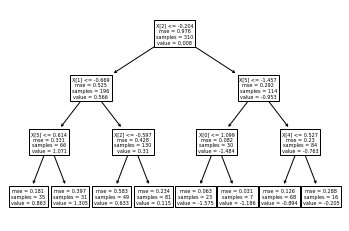

In [45]:
from sklearn import tree
tree.plot_tree(DTR)

# Scrap

In [ ]:
boston = load_boston()
X = pd.DataFrame(boston['data'], columns=boston['feature_names'])
y = pd.Series(boston['target'], name='House Price')
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
def prepare_dataset():
    boston = load_boston()
    X_y = np.column_stack([boston['data'], boston['target']])
    np.random.seed(1)
    np.random.shuffle(X_y)
    X, y = X_y[:,:-1], X_y[:,-1]
    X_train, y_train, X_test, y_test = X[:400], y[:400], X[400:], y[400:]
    X_train = pd.DataFrame(X_train, columns=boston['feature_names'])
    X_test = pd.DataFrame(X_test, columns=boston['feature_names'])
    y_train = pd.Series(y_train, name='House Price')
    y_test = pd.Series(y_test, name='House Price')
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = prepare_dataset()
X_train.head()

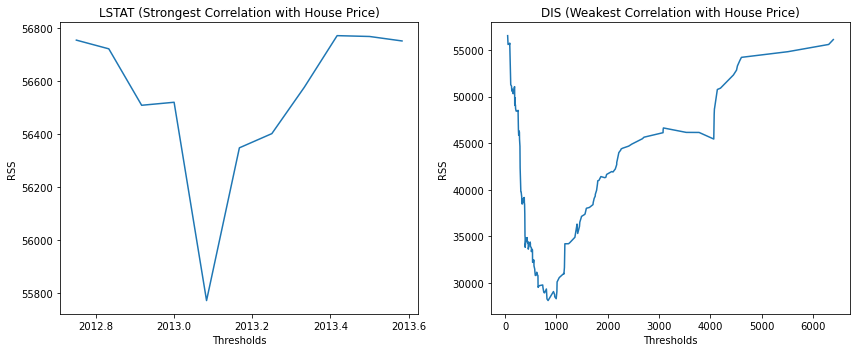

In [35]:
lstat_thresholds, lstat_rss = compute_rss_by_threshold('X1')
dis_thresholds, dis_rss = compute_rss_by_threshold('X3')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.xlabel('Thresholds')
plt.ylabel('RSS')
plt.title('LSTAT (Strongest Correlation with House Price)')
plt.plot(lstat_thresholds, lstat_rss)

plt.subplot(1, 2, 2)
plt.xlabel('Thresholds')
plt.ylabel('RSS')
plt.title('DIS (Weakest Correlation with House Price)')
plt.plot(dis_thresholds, dis_rss)

plt.tight_layout()
plt.show()

In [47]:
# Initiating the Node
root = NodeRegression(y_train, X_train, max_depth=2, min_samples_split=3)
# Growing the tree
root.grow_tree()

In [48]:
root.print_tree()

Root
   | MSE of the node: 183.14
   | Count of observations in node: 310
   | Prediction of node: 37.836
|-------- Split rule: X3 <= 826.827
           | MSE of the node: 113.56
           | Count of observations in node: 193
           | Prediction of node: 45.324
|---------------- Split rule: X2 <= 11.7
                   | MSE of the node: 115.76
                   | Count of observations in node: 70
                   | Prediction of node: 52.579
|---------------- Split rule: X2 > 11.7
                   | MSE of the node: 65.32
                   | Count of observations in node: 123
                   | Prediction of node: 41.196
|-------- Split rule: X3 > 826.827
           | MSE of the node: 52.86
           | Count of observations in node: 117
           | Prediction of node: 25.485
|---------------- Split rule: X6 <= 121.509
                   | MSE of the node: 13.35
                   | Count of observations in node: 26
                   | Prediction of node: 17.369
|-----

In [45]:
# Data wrangling 
import pandas as pd 

# Array math
import numpy as np 

# Quick value count calculator
from collections import Counter


class NodeRegression():
    """
    Class to grow a regression decision tree
    """
    def __init__(
        self, 
        Y: list,
        X: pd.DataFrame,
        min_samples_split=None,
        max_depth=None,
        depth=None,
        node_type=None,
        rule=None
    ):
        # Saving the data to the node 
        self.Y = Y 
        self.X = X

        # Saving the hyper parameters
        self.min_samples_split = min_samples_split if min_samples_split else 20
        self.max_depth = max_depth if max_depth else 5

        # Default current depth of node 
        self.depth = depth if depth else 0

        # Extracting all the features
        self.features = list(self.X.columns)

        # Type of node 
        self.node_type = node_type if node_type else 'root'

        # Rule for spliting 
        self.rule = rule if rule else ""

        # Getting the mean of Y 
        self.ymean = np.mean(Y)

        # Getting the residuals 
        self.residuals = self.Y - self.ymean

        # Calculating the mse of the node 
        self.mse = self.get_mse(Y, self.ymean)

        # Saving the number of observations in the node 
        self.n = len(Y)

        # Initiating the left and right nodes as empty nodes
        self.left = None 
        self.right = None 

        # Default values for splits
        self.best_feature = None 
        self.best_value = None 

    @staticmethod
    def get_mse(ytrue, yhat) -> float:
        """
        Method to calculate the mean squared error 
        """
        # Getting the total number of samples
        n = len(ytrue)

        # Getting the residuals 
        r = ytrue - yhat 

        # Squering the residuals 
        r = r ** 2

        # Suming 
        r = np.sum(r)

        # Getting the average and returning 
        return r / n

    @staticmethod
    def ma(x: np.array, window: int) -> np.array:
        """
        Calculates the moving average of the given list. 
        """
        return np.convolve(x, np.ones(window), 'valid') / window

    def best_split(self) -> tuple:
        """
        Given the X features and Y targets calculates the best split 
        for a decision tree
        """
        # Creating a dataset for spliting
        df = self.X.copy()
        df['Y'] = self.Y

        # Getting the GINI impurity for the base input 
        mse_base = self.mse

        # Finding which split yields the best GINI gain 
        #max_gain = 0

        # Default best feature and split
        best_feature = None
        best_value = None

        for feature in self.features:
            # Droping missing values
            Xdf = df.dropna().sort_values(feature)

            # Sorting the values and getting the rolling average
            xmeans = self.ma(Xdf[feature].unique(), 2)

            for value in xmeans:
                # Getting the left and right ys 
                left_y = Xdf[Xdf[feature]<value]['Y'].values
                right_y = Xdf[Xdf[feature]>=value]['Y'].values

                # Getting the means 
                left_mean = np.mean(left_y)
                right_mean = np.mean(right_y)

                # Getting the left and right residuals 
                res_left = left_y - left_mean 
                res_right = right_y - right_mean

                # Concatenating the residuals 
                r = np.concatenate((res_left, res_right), axis=None)

                # Calculating the mse 
                n = len(r)
                r = r ** 2
                r = np.sum(r)
                mse_split = r / n

                # Checking if this is the best split so far 
                if mse_split < mse_base:
                    best_feature = feature
                    best_value = value 

                    # Setting the best gain to the current one 
                    mse_base = mse_split

        return (best_feature, best_value)

    def grow_tree(self):
        """
        Recursive method to create the decision tree
        """
        # Making a df from the data 
        df = self.X.copy()
        df['Y'] = self.Y

        # If there is GINI to be gained, we split further 
        if (self.depth < self.max_depth) and (self.n >= self.min_samples_split):

            # Getting the best split 
            best_feature, best_value = self.best_split()

            if best_feature is not None:
                # Saving the best split to the current node 
                self.best_feature = best_feature
                self.best_value = best_value

                # Getting the left and right nodes
                left_df, right_df = df[df[best_feature]<=best_value].copy(), df[df[best_feature]>best_value].copy()

                # Creating the left and right nodes
                left = NodeRegression(
                    left_df['Y'].values.tolist(), 
                    left_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split, 
                    node_type='left_node',
                    rule=f"{best_feature} <= {round(best_value, 3)}"
                    )

                self.left = left 
                self.left.grow_tree()

                right = NodeRegression(
                    right_df['Y'].values.tolist(), 
                    right_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split,
                    node_type='right_node',
                    rule=f"{best_feature} > {round(best_value, 3)}"
                    )

                self.right = right
                self.right.grow_tree()

    def print_info(self, width=4):
        """
        Method to print the infromation about the tree
        """
        # Defining the number of spaces 
        const = int(self.depth * width ** 1.5)
        spaces = "-" * const
        
        if self.node_type == 'root':
            print("Root")
        else:
            print(f"|{spaces} Split rule: {self.rule}")
        print(f"{' ' * const}   | MSE of the node: {round(self.mse, 2)}")
        print(f"{' ' * const}   | Count of observations in node: {self.n}")
        print(f"{' ' * const}   | Prediction of node: {round(self.ymean, 3)}")   

    def print_tree(self):
        """
        Prints the whole tree from the current node to the bottom
        """
        self.print_info() 
        
        if self.left is not None: 
            self.left.print_tree()
        
        if self.right is not None:
            self.right.print_tree()